In [25]:
# collection of functions
# simple functions could be tested within the cell it is defined
# more complex ones uses the cell below to do the testing
# rules: 
# 1, each function should not take longer than 1min to run
# 2, not too long... 20 lines?

In [26]:
# for plots
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12
import warnings
warnings.filterwarnings('ignore')
from util.gamap_colormap import WhGrYlRd
# packages
import math
import matplotlib.pyplot as plt # load plotting libraries
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import regionmask


In [27]:
# same as above, only long names
def long_name_of_month(month): # returns long name of month
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    name_month = month_names[month-1]
    return name_month
#long_name_of_month(5)

In [28]:
# input: 3
# output: 'Mar'
def short_name_of_month(month): # returns short name of month
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    name_month = month_names[month-1]
    return name_month
#short_name_of_month(12)

In [29]:
# input: 2018, 2
# output: array(['2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', ..., '2018-02-27', '2018-02-28'], dtype='datetime64[D]')
# needs some work
def days_str_in_a_month(year, month): # returns days in a month, in numpy datetime64[D] format
    month_str = month_string(month)
    if month <= 11:
        first_day = str(year) + '-' + month_str + '-01'
        month_str_p1 = month_string(month+1)
        last_day_p1 = str(year) + '-' + month_str_p1 + '-01'
    else:
        first_day = str(year) + '-' + month_str + '-01'
        month_str_p1 = month_string(1)
        last_day_p1 = str(year+1) + '-' + month_str_p1 + '-01'
    
    return np.arange(first_day, last_day_p1, dtype='datetime64[D]')
#days_str_in_a_month(2018,1)

In [30]:
# input: number of month: 1-12
# output: a string '01', '02', '03', ..., '10', '11', '12'
def month_string(month): # string for a month, input 3 output '03'
    if(month >= 10):
        mm_str = str(month)
    else:
        mm_str = '0' + str(month)
    return mm_str
#month_string(3)

In [52]:
# a correct leap year function! might not needed at all
# input: year in integer
# output: True if leap year, False if not
def leap_year(year):
    ans = False
    if year%4 == 0 and year%100 !=0:
        ans = True
    if year%400 == 0:
        ans = True
    return ans
leap_year(2012)

True

In [59]:
def days_in_month(year, month):
    leap_flag = leap_year(year)
    days_in_a_year = [31,28,31,30,31,30,31,31,30,31,30,31]
    if leap_flag == True and month == 2: return 29
    else: return days_in_a_year[month-1]

#days_in_month(2010,2)

In [32]:
# Approximate the area of a spatial grid square from the latitudes and longitudes of the diagonal vertices
def area_latlon(lat1, lon1, lat2, lon2):
    # This function calculates the area (in km^2) of a spatial grid square, given the latitudes and longitudes of the two diagonal vertices of the grid square.
    # lat/lon is in angle; lat: [-90:90]; lon:[-180:180].
    # lat1/lon1 and lat2/lon2 are thus the diagonal vertices of the square grid.
    lat1 = lat1/180*np.pi
    lat2 = lat2/180*np.pi
    lon1 = lon1/180*np.pi
    lon2 = lon2/180*np.pi
    A = np.absolute(6371.009**2*(np.sin(lat2)-np.sin(lat1))*(lon2-lon1))
    return A
#area_latlon(10,0,11,1)

In [35]:
# input: an xarray dataarray or dataset with lon and lat coords
# output: [[lat1,lon1], [lat2,lon2]], smallest box that covers dataset
def lat_lon_bounds(ds):
    minlat = math.floor(ds.lat.min())
    maxlat = math.ceil(ds.lat.max())
    minlon = math.floor(ds.lon.min())
    maxlon = math.ceil(ds.lon.max())
    mins = [minlat, minlon] 
    maxs = [maxlat, maxlon]
    
    # round up to nearest number divisible by 5, GEOS-Chem grids keep these grid points even (?)
    for i in range(len(mins)):
        if mins[i]%5 != 0: mins[i] = mins[i] - mins[i]%5
    for i in range(len(maxs)):
        if maxs[i]%5 != 0: maxs[i] = maxs[i] + 5 - maxs[i]%5
    ans = [mins,maxs]   
    return ans


In [36]:
#fname = '/geos/d21/msadiq/TNO-GHGco/gridded/TNO_2018_0.05x0.1.nc'
#ds = xr.open_dataset(fname)
#lat_lon_bounds(ds)

[[30, -30], [75, 60]]

In [38]:
# get country total of a variable
def country_totals(co2_xarray, countries, varnames):
    # create masks using regionmask
    mask1 = regionmask.defined_regions.natural_earth.countries_50.mask(co2_xarray)
    # sum up total emissions for each country
    co2_countries = co2_xarray.groupby(mask1).sum('stacked_lat_lon')
    abbrevs = regionmask.defined_regions.natural_earth.countries_50[co2_countries.region.values].abbrevs
    names = regionmask.defined_regions.natural_earth.countries_50[co2_countries.region.values].names
    co2_countries.coords['abbrevs'] = ('region', abbrevs)
    co2_countries.coords['names'] = ('region', names)

    country_totals = np.zeros(len(countries))
    for i in range(len(countries)):
        tmp = co2_countries.isel(region=(co2_countries.names == countries[i]))
        country_totals[i] = tmp[varnames[0]].values
    return country_totals


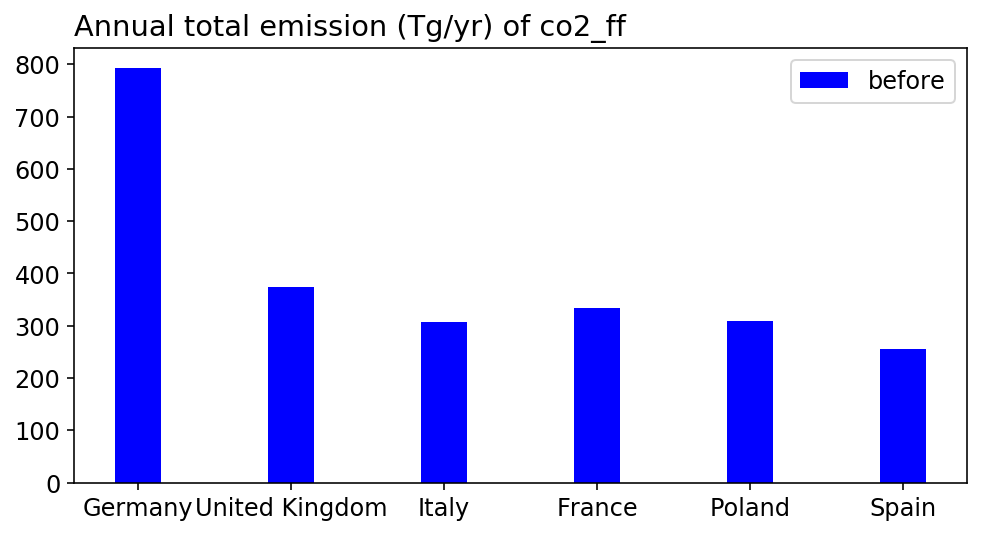

In [45]:
#fname = '/geos/d21/msadiq/TNO-GHGco/gridded/TNO_2018_0.05x0.1.nc'
#ds = xr.open_dataset(fname)

#countries = ['Germany', 'United Kingdom', 'Italy', 'France', 'Poland', 'Spain']
#var    = ['co2_ff']
#before = country_totals(ds[var], countries, var)

#bar_pos = np.arange(len(countries)) + 1 # position of the bars
#fig = plt.figure(figsize=[8, 4])
#width = 0.3
#bars_before = plt.bar(bar_pos, before*1e-9, width=width, color = 'b', label='before')
#plt.xticks(bar_pos, countries)
#plt.title('Annual total emission (Tg/yr) of ' + var[0], loc='left')
#plt.legend()

In [37]:
# regrid an xarray dataarray from finer resolution to coarser resolution (res)
# ds is the dataset, varnames are variables need to be regridded
def regrid_fine_to_coarse_sum(ds, varnames, res_lat, res_lon):
    # get outer bounds of input data, [[lat1,lon1], [lat2,lon2]] 
    bounds = lat_lon_bounds(ds)
    # target grid
    target = xr.DataArray(0, dims=('lat', 'lon'), 
                            coords={'lat': np.arange(bounds[0][0], bounds[1][0] + res_lat, res_lat), # larger than CHE domain
                                    'lon': np.arange(bounds[0][1], bounds[1][1] + res_lon, res_lon)}) # slightly smaller than TNO domain
    target = target.astype(dtype='float64')
    output = target.to_dataset(name = varnames[0])
    for ivar in varnames: output[ivar] = target.copy()
    # regridding
    for ivar in varnames:
        dr = ds[ivar]
        for ilon, lon in enumerate(target['lon'].values):
            for ilat, lat in enumerate(target['lat'].values):
                subset = dr.sel(lat=slice(lat-res_lat/2,lat+res_lat/2), lon = slice(lon-res_lon/2,lon+res_lon/2))
                target[ilat,ilon] = subset.sum().values
                target.attrs = dr.attrs
        output[ivar] = target.copy()
    return output


CPU times: user 1min 36s, sys: 741 ms, total: 1min 37s
Wall time: 1min 37s


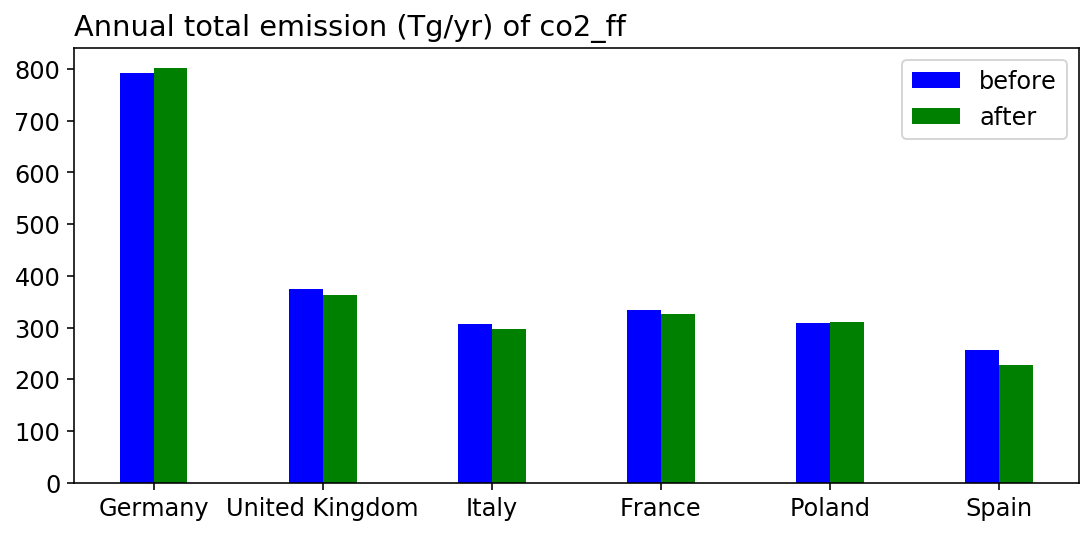

In [49]:
#%%time
#fname = '/geos/d21/msadiq/TNO-GHGco/gridded/TNO_2018_0.05x0.1.nc'
#ds = xr.open_dataset(fname)
#ds_regrid = regrid_fine_to_coarse_sum(ds, ['co2_ff'], 0.25, 0.3125)

#countries = ['Germany', 'United Kingdom', 'Italy', 'France', 'Poland', 'Spain']
#var    = ['co2_ff']
#before = country_totals(ds[var], countries, var)
#after  = country_totals(ds_regrid[var], countries, var)

#bar_pos = np.arange(len(countries)) + 1 # position of the bars
#fig = plt.figure(figsize=[9, 4])
#width = 0.2
#bars_before = plt.bar(bar_pos-0.1, before*1e-9, width=width, color = 'b', label='before')
#bars_after  = plt.bar(bar_pos+0.1, after*1e-9, width=width, color = 'g', label='after')
#plt.xticks(bar_pos, countries)
#plt.title('Annual total emission (Tg/yr) of ' + var[0], loc='left')
#plt.legend()

In [60]:
# convert kg/year to kg/m2/s
def unit_convert1(ds, varnames, res_lat, res_lon):
    for ivar in varnames:
        dr = ds[ivar]
        # calculate grid area (using the area_latlon) and compute flux
        for ilat, lat in enumerate(dr['lat'].values):
            area = 1e6 * area_latlon(lat1=lat, lat2=lat+res_lat, 
                                     lon1=10, lon2=10+res_lon) # m^2, longitude doesn't matter
            dr[ilat,:] = dr[ilat,:]/(area*3600*24*365) # kg/m2/s
        ds[ivar] = dr.copy()
        ds[ivar].attrs['units'] = 'kg/m2/s'
        ds[ivar].attrs['long_units'] = 'kg(' + ivar + ')/m2/s'
    return ds


In [66]:
#fname = '/geos/d21/msadiq/TNO-GHGco/gridded/TNO_2018_0.05x0.1.nc'
#ds = xr.open_dataset(fname)
#ds_flux = unit_convert1(ds, ['co2_ff'], 0.05, 0.1)
#ds_flux['co2_ff'].plot()

In [67]:
#convert annual mean kg/m2/s to kg/year
def unit_convert2(ds, varnames, res_lat, res_lon):
    for ivar in varnames:
        dr = ds[ivar]
        # use grid area function
        for ilat, lat in enumerate(dr.lat.values):
            area = 1e6 * area_latlon(lat1 = lat, lat2 = lat + res_lat,
                                     lon1 = 10, lon2 = 10 + res_lon) # m^2, longitude doesn't matter
            dr[ilat,:] = dr[ilat,:] * area * (3600*24*365) # kg/year
        ds[ivar] = dr.copy()
        ds[ivar].attrs['units'] = 'kg/year'
        ds[ivar].attrs['long_units'] = 'kg(' + ivar + ')/year'
    return ds


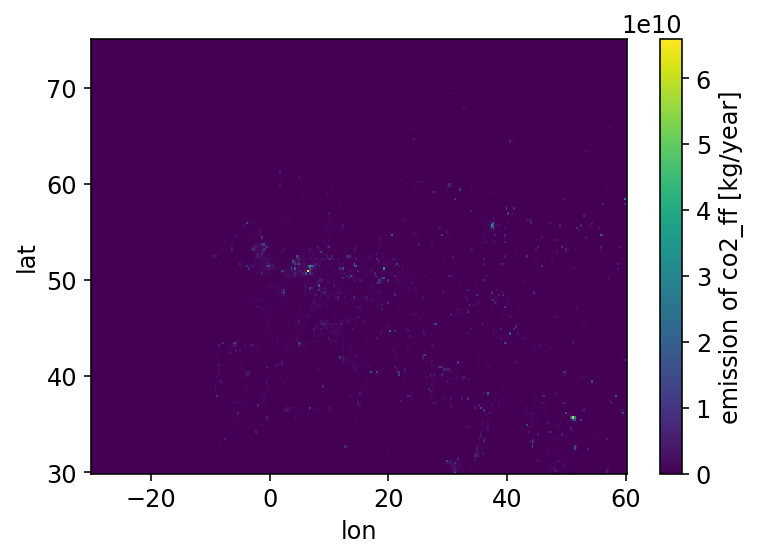

In [68]:
#fname = '/geos/d21/msadiq/TNO-GHGco/gridded/TNO_2018_0.25x0.3125.nc'
#ds = xr.open_dataset(fname)
#ds_flux = unit_convert2(ds, ['co2_ff'], 0.25, 0.3125)
#ds_flux['co2_ff'].plot()